2. Apply a few ML algorithms.
 - We'll use the taxi data first.
      - The taxi pricing model is very clear and there is no surging
      - There is more taxi data, and the model is known to be consistent since Jan 2016 (see prev. notebook)
 - Linear model with the extra categorical variables included. 

### Machine Learning on the cleaned data + addl features
https://ramhiser.com/post/2018-04-16-building-scikit-learn-pipeline-with-pandas-dataframe/


In [2]:
import pandas as pd
import numpy as np
import pickle
from Fair_Fare.feature_utils import load_hdf

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import dump, load

import xgboost as xgb
import datetime as dt

from scipy.stats import randint, uniform

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [3]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])


preprocess_pipeline = make_pipeline(
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            OneHotEncoder(categories = 'auto')
        )),
        ("boolean_features", make_pipeline(
            TypeSelector("bool")
        ))
    ])
)


In [4]:
# Linear fit to taxi
X = load_hdf('data/taxi_train.h5',0.1)
#preprocess_pipeline.fit(X)

y = X["Final_Fare"]
X.drop(["Final_Fare"], axis = 1, inplace = True)


#lin_reg = LinearRegression(preprocess_pipeline,n_jobs = -1)
#lin_reg.fit(X,y)
#dump(lin_reg, 'taxi_lin_model.joblib') 

In [5]:
lin_reg = load('taxi_lin_model.joblib')
lin_mse = mean_squared_error(lin_reg.predict(X), y)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.7959909889442263

In [ ]:
lin_scores = cross_val_score(lin_reg, X, y,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [11]:
# Linear fit to tnp
X = load_hdf('data/tnp_train.h5',100)

#preprocess_pipeline.fit(X)

y = X["Final_Fare"]
X.drop(["Final_Fare"], axis = 1, inplace = True)


lin_reg = LinearRegression(preprocess_pipeline,n_jobs = -1)
lin_reg.fit(X,y)
dump(lin_reg, 'tnp_lin_model.joblib') 

['tnp_lin_model.joblib']

## Xgboost 

In [39]:
#taxi

X = load_hdf('data/taxi_train.h5',.2)
y = X["Final_Fare"]
X.drop(["Final_Fare"], axis = 1, inplace = True)

Xv = load_hdf('data/taxi_train.h5',.2)
yv = Xv["Final_Fare"]
Xv.drop(["Final_Fare"], axis = 1, inplace = True)


dvalid = xgb.DMatrix(Xv.values, label=yv.values)
dtrain = xgb.DMatrix(X.values, label=y.values)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]


xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 6, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:squarederror'}

t0 = dt.datetime.now()
model = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=100)

t1 = dt.datetime.now()
print('Modeling RMSLE %.5f' % model.best_score)
print('Training time: %i seconds' % (t1 - t0).seconds)

[0]	train-rmse:13.7666	valid-rmse:13.7918
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:1.3518	valid-rmse:1.69911
[200]	train-rmse:1.17692	valid-rmse:1.67242
Stopping. Best iteration:
[237]	train-rmse:1.1284	valid-rmse:1.66123

Modeling RMSLE 1.66123
Training time: 3 seconds


In [40]:
feature_importance_dict = model.get_fscore()
feature_names = X.columns
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance_taxi = feature_importance.fillna(0)

In [31]:
feature_importance_taxi[['feature_name', 'importance']].sort_values(by='importance', ascending=False)

,feature_name,importance
12,Trip_Seconds,696
0,l2_dist_km,577
7,y_dist_km,550
10,x_dist_km,469
9,vel_mph,468
8,Trip_Miles,437
1,Dropoff_Centroid_Longitude,426
5,bearing,377
13,Pickup_Centroid_Longitude,358
2,Pickup_Centroid_Latitude,318


In [6]:
#tnp

X = load_hdf('data/tnp_train.h5',.2)
y = X["Final_Fare"]
X.drop(["Final_Fare"], axis = 1, inplace = True)

Xv = load_hdf('data/tnp_train.h5',.2)
yv = Xv["Final_Fare"]
Xv.drop(["Final_Fare"], axis = 1, inplace = True)


dvalid = xgb.DMatrix(Xv.values, label=yv.values)
dtrain = xgb.DMatrix(X.values, label=y.values)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]


xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 6, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:squarederror'}

t0 = dt.datetime.now()
model = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=100)

t1 = dt.datetime.now()
print('Modeling RMSLE %.5f' % model.best_score)
print('Training time: %i seconds' % (t1 - t0).seconds)

[0]	train-rmse:10.1712	valid-rmse:10.2871
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[35]	train-rmse:2.37977	valid-rmse:2.97775

Modeling RMSLE 2.97775
Training time: 1 seconds


In [7]:
feature_importance_taxi

NameError: name 'feature_importance_taxi' is not defined

In [54]:
pd.merge(feature_importance, feature_importance_taxi, how='right', on='f').to_pickle("./importance.pkl")

In [42]:
feature_importance_dict = model.get_fscore()
feature_names = X.columns
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

In [49]:
feature_importance.sort_values(by='importance', ascending=False, inplace = True)
feature_importance_taxi.sort_values(by='importance', ascending=False,inplace = True)

In [52]:
print(feature_importance, feature_importance_taxi)
pd.merge(feature_importance, feature_importance_taxi, how='right', on='f').to_pickle("./importance.pkl")

      f  importance                feature_name
12   f0         661                Trip_Seconds
0   f10         564                  l2_dist_km
7   f12         490                   y_dist_km
9    f9         471                     vel_mph
11  f11         469                   x_dist_km
8    f1         437                  Trip_Miles
6   f13         393                     bearing
1    f8         390  Dropoff_Centroid_Longitude
13   f6         355   Pickup_Centroid_Longitude
5    f7         292   Dropoff_Centroid_Latitude
2    f5         291    Pickup_Centroid_Latitude
3   f15         219                   day_of_wk
16   f2         175       Pickup_Community_Area
14  f16         163                        hour
10   f3         148      Dropoff_Community_Area
15   f4          21      Shared_Trip_Authorized
4   f14          13                    bAirport       f  importance                feature_name
11   f8        1495                     vel_mph
7   f12        1425                     

In [29]:
# param search
# see https://xgboost.readthedocs.io/en/latest/parameter.html

param_dist = {'max_depth': randint(low=4, high=20),
              'n_estimators': randint(low=20, high=400),
              'min_child_weight':randint(low=5, high=200),
              'eta':uniform(0.15,.2),
              'colsample_bytree':uniform(0.2,.4),
              'subsample': uniform(0.4,.5),
              'lambda': uniform(0.5,3.)
             }
xgb_model = xgb.XGBRegressor({
              'booster' : 'gbtree', 'eval_metric': 'rmse','silent': 1, 'objective': 'reg:squarederror'})
clf =  RandomizedSearchCV(xgb_model,
                   param_dist, verbose=1,n_jobs = 7,n_iter=200, cv=4, scoring='neg_mean_squared_error')
clf.fit(X.values,y.values)
print(clf.best_score_)
print(clf.best_params_)


Fitting 4 folds for each of 200 candidates, totalling 800 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


KeyboardInterrupt: 

In [54]:
cvres = clf.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.7123291437145671 {'colsample_bytree': 0.5567229659693154, 'eta': 0.2643172145557544, 'lambda': 0.6145159608205376, 'max_depth': 11, 'min_child_weight': 115, 'n_estimators': 318, 'subsample': 0.7646243506947745}
1.7767354941591014 {'colsample_bytree': 0.4188809148764538, 'eta': 0.3299295153083107, 'lambda': 2.761794126461167, 'max_depth': 18, 'min_child_weight': 184, 'n_estimators': 397, 'subsample': 0.6665119794338152}
1.9121555538543245 {'colsample_bytree': 0.5202082492247373, 'eta': 0.32545965223976264, 'lambda': 1.241946634658322, 'max_depth': 6, 'min_child_weight': 197, 'n_estimators': 233, 'subsample': 0.41743556955877004}
1.722405998095129 {'colsample_bytree': 0.4638224522464749, 'eta': 0.15189091750876899, 'lambda': 1.0742024443090579, 'max_depth': 14, 'min_child_weight': 136, 'n_estimators': 381, 'subsample': 0.7288450390694795}
1.7845215242331083 {'colsample_bytree': 0.5493204407872195, 'eta': 0.16299402175828062, 'lambda': 2.788994943025087, 'max_depth': 14, 'min_child_weig

### Full model training

In [ ]:
{'colsample_bytree': 0.4659175029639101, 'eta': 0.30900240687858116, 'lambda': 3.335261321413178, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 355, 'subsample': 0.7367235778794784}

In [2]:
X = load_hdf('data/taxi_train.h5',100)

y = X["Final_Fare"].copy()
X.drop(["Final_Fare"], axis = 1, inplace = True)


X_train, Xv, y_train, yv = train_test_split(X, y, test_size=0.2, random_state=42)

dvalid = xgb.DMatrix(Xv.values, label=yv.values)
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)


In [5]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]



xgb_pars = {'colsample_bytree': 0.4659175029639101, 'eta': 0.30900240687858116, 
            'lambda': 3.335261321413178, 'max_depth': 7, 'min_child_weight': 8, 
            'n_estimators': 355, 'subsample': 0.7367235778794784, 'nthread': 6, 
            'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:squarederror'}


t0 = dt.datetime.now()
model = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=1)

t1 = dt.datetime.now()
print('Modeling RMSLE %.5f' % model.best_score)
print('Training time: %i seconds' % (t1 - t0).seconds)

[0]	train-rmse:13.4387	valid-rmse:13.4353
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:9.67493	valid-rmse:9.67632
[2]	train-rmse:6.84618	valid-rmse:6.84827
[3]	train-rmse:4.91189	valid-rmse:4.91369
[4]	train-rmse:3.63353	valid-rmse:3.635
[5]	train-rmse:2.90893	valid-rmse:2.91197
[6]	train-rmse:2.46996	valid-rmse:2.4737
[7]	train-rmse:2.23058	valid-rmse:2.23484
[8]	train-rmse:2.10806	valid-rmse:2.11241
[9]	train-rmse:1.92299	valid-rmse:1.92635
[10]	train-rmse:1.88641	valid-rmse:1.88981
[11]	train-rmse:1.79633	valid-rmse:1.79814
[12]	train-rmse:1.72469	valid-rmse:1.72623
[13]	train-rmse:1.68272	valid-rmse:1.68319
[14]	train-rmse:1.67338	valid-rmse:1.67409
[15]	train-rmse:1.65009	valid-rmse:1.6504
[16]	train-rmse:1.63574	valid-rmse:1.63621
[17]	train-rmse:1.62128	valid-rmse:1.62129
[18]	train-rmse:1.61167	valid-rmse:1.61154
[19]	train-rmse:1.60974	valid-rmse:1.60957
[20]	trai

In [6]:
#model.save_model("taxi_xgb_full")

In [ ]:
import pickle

In [10]:
# TNP param tuning

tnp = load_hdf('data/tnp_train.h5',.02)

y = tnp["Final_Fare"].copy()
X = tnp.drop(["Final_Fare"], axis = 1)


X_train, Xv, y_train, yv = train_test_split(X, y, test_size=0.2, random_state=42)

dvalid = xgb.DMatrix(Xv.values, label=yv.values)
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)

param_dist = {'max_depth': randint(low=4, high=20),
              'n_estimators': randint(low=20, high=400),
              'min_child_weight':randint(low=5, high=200),
              'eta':uniform(0.15,.2),
              'colsample_bytree':uniform(0.2,.4),
              'subsample': uniform(0.4,.5),
              'lambda': uniform(0.5,3.)
             }

xgb_model = xgb.XGBRegressor({
              'booster' : 'gbtree', 'eval_metric': 'rmse','silent': 1, 'objective': 'reg:squarederror'})
clf =  RandomizedSearchCV(xgb_model,
                   param_dist, verbose=1,n_jobs = 7,n_iter=300, cv=5, scoring='neg_mean_squared_error')
clf.fit(X.values,y.values)
print(clf.best_score_)
print(clf.best_params_)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    5.0s


KeyboardInterrupt: 

In [3]:
X = load_hdf('data/tnp_train.h5',100)

y = X["Final_Fare"].copy()
X.drop(["Final_Fare"], axis = 1, inplace = True)


X_train, Xv, y_train, yv = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
dvalid = xgb.DMatrix(Xv.values, label=yv.values)
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)

In [7]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]


xgb_pars = {'colsample_bytree': 0.5994699901820792, 'eta': 0.16180028105758762, 
            'lambda': 0.697099727254144, 'max_depth': 5, 'min_child_weight': 25, 
            'n_estimators': 125, 'subsample': 0.8213364096819988, 'nthread': 7, 
            'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:squarederror'}


t0 = dt.datetime.now()
model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=1)

t1 = dt.datetime.now()
print('Modeling RMSLE %.5f' % model.best_score)
print('Training time: %i seconds' % (t1 - t0).seconds)

model.save_model("tnp_xgb_full")

[0]	train-rmse:11.8992	valid-rmse:11.9038
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1]	train-rmse:10.1238	valid-rmse:10.1291
[2]	train-rmse:8.65287	valid-rmse:8.65893
[3]	train-rmse:7.49376	valid-rmse:7.50048
[4]	train-rmse:6.55277	valid-rmse:6.5601
[5]	train-rmse:5.7504	valid-rmse:5.75818
[6]	train-rmse:5.14227	valid-rmse:5.15029
[7]	train-rmse:4.58652	valid-rmse:4.59449
[8]	train-rmse:4.20653	valid-rmse:4.21434
[9]	train-rmse:3.91328	valid-rmse:3.92052
[10]	train-rmse:3.62797	valid-rmse:3.6352
[11]	train-rmse:3.45539	valid-rmse:3.46236
[12]	train-rmse:3.28572	valid-rmse:3.2925
[13]	train-rmse:3.16147	valid-rmse:3.16806
[14]	train-rmse:3.06217	valid-rmse:3.06853
[15]	train-rmse:2.98881	valid-rmse:2.99492
[16]	train-rmse:2.9364	valid-rmse:2.94227
[17]	train-rmse:2.90733	valid-rmse:2.91309
[18]	train-rmse:2.87656	valid-rmse:2.88216
[19]	train-rmse:2.85638	valid-rmse:2.86189
[20]	train

### Test set evaluation

Here we predict on the witheld data to confirm the quality of our estimators.

In [18]:
taxi_linmod = load('taxi_lin_model.joblib')
taxi_treemod = xgb.Booster()
taxi_treemod.load_model("taxi_xgb_full")

tnp_linmod = load('tnp_lin_model.joblib')
tnp_treemod = xgb.Booster()
tnp_treemod.load_model("tnp_xgb_full")

In [33]:
errors = []
samples = []
features = []

X = load_hdf('data/taxi_test.h5',100)
#these should have been dropped earlier...
X.drop(X[X["Final_Fare"]>500].index, inplace = True)
y = X["Final_Fare"]
X.drop(["Final_Fare"], axis = 1, inplace = True)
dtest = xgb.DMatrix(X.values, label=y.values)

pred_tree = taxi_treemod.predict(dtest)
pred_lin = taxi_linmod.predict(X)
samples.append(X.size)
features.append(len(X.columns))

errors.append(np.sqrt(mean_squared_error(y, pred_tree)))
errors.append(np.sqrt(mean_squared_error(y, pred_lin)))

print("XG tree RMSE: ",np.sqrt(mean_squared_error(y, pred_tree)))
print("Linear RMSE :", np.sqrt(mean_squared_error(y, pred_lin)))

XG tree RMSE:  1.6650221
Linear RMSE : 2.9674565977800547


In [34]:
X = load_hdf('data/tnp_test.h5',100)
y = X["Final_Fare"]
X.drop(["Final_Fare"], axis = 1, inplace = True)
dtest = xgb.DMatrix(X.values, label=y.values)

pred_tree = tnp_treemod.predict(dtest)
pred_lin = tnp_linmod.predict(X)

errors.append(np.sqrt(mean_squared_error(y, pred_tree)))
errors.append(np.sqrt(mean_squared_error(y, pred_lin)))
samples.append(X.size)
features.append(len(X.columns))



print("XG tree RMSE: ",np.sqrt(mean_squared_error(y, pred_tree)))
print("Linear RMSE :", np.sqrt(mean_squared_error(y, pred_lin)))

XG tree RMSE:  2.6830482
Linear RMSE : 3.1459173678591887


In [65]:
X = load_hdf('data/tnp_test.h5',100)
y = X["Final_Fare"]
X.drop(["Final_Fare","Shared_Trip_Authorized"], axis = 1, inplace = True)
dtest = xgb.DMatrix(X.values, label=y.values)

taxi_treemod.predict(dtest)

array([23.455196 , 17.450554 , 19.038605 , ..., 46.223186 , 40.795383 ,
        7.0205503], dtype=float32)

In [22]:
X = load_hdf('data/tnp_test.h5',1)
y = X["Final_Fare"]
X.drop(["Final_Fare","Shared_Trip_Authorized"], axis = 1, inplace = True)
dtest = xgb.DMatrix(X.values, label=y.values)

taxi_treemod.predict(dtest)
taxi_on_tnp = taxi_treemod.predict(dtest)
diff = taxi_on_tnp - y
diff[diff>0].count()/diff[diff<0].count()

3.9685308984183925

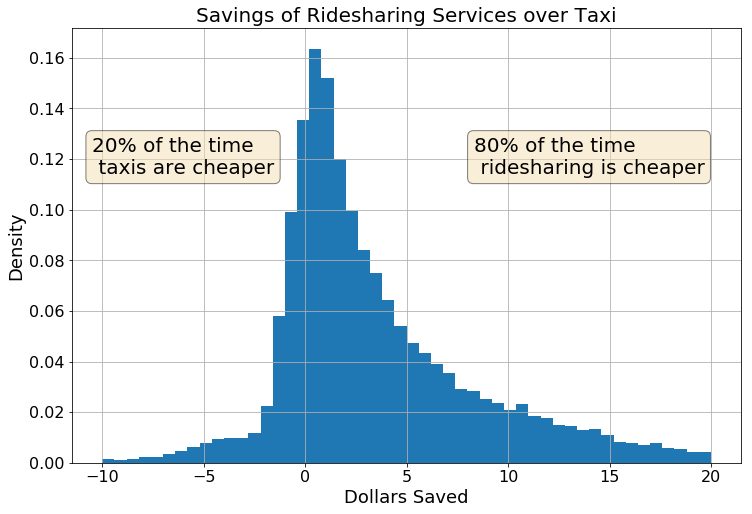

In [87]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

diff.hist(bins = 50, figsize = (12,12),range=[-10,20], log = False,density = True)
plt.title("Savings of Ridesharing Services over Taxi", fontsize = 20)
plt.xlabel("Dollars Saved", fontsize = 18)
plt.ylabel("Density", fontsize = 18)
plt.text(0.03, 0.75, "20% of the time\n taxis are cheaper", transform=plt.gca().transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

plt.text(0.6, 0.75, "80% of the time\n ridesharing is cheaper", transform=plt.gca().transAxes, fontsize=20,
        verticalalignment='top', bbox=props)
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.savefig('Rideshare_savings.png', dpi=100)

In [85]:
diff[diff>0].count()/diff.count()

0.798733263323707

In [86]:
diff[diff<0].count()/diff.count()

0.201266736676293

In [73]:
diff[diff<0].count()

601746